In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python mediapipe sklearn matplotlib

In [ ]:
from matplotlib import pyplot as plt
import mediapipe as mp
import numpy as np
import time
import cv2
import os
import seaborn as sns
import pandas as pd

### Mediapipe object and utils

- In this part, we first the functions necessary for the data collection and detection. 

**mp.solutions.holistic** - MediaPipe Holistic utilizes the pose, face and hand landmark models in MediaPipe Pose, MediaPipe Face Mesh and MediaPipe Hands respectively to generate a total of 543 landmarks (33 pose landmarks, 468 face landmarks, and 21 hand landmarks per hand).

**mp.solutions.drawing_utils** - utils used for drawing the keypoints on the image/frame.

> FUNCTIONS:
- **detect_mpLeypoints()** - this function will change the image from BGR to RGB as well as setting it to non-rewritable before detecting keypoints in the frame using mediapipe.
- **custom_keypoints()** - it customizes the design of your keypoints in the frame.
- **get_keypoints()** - it extracts the array values of each keypoint's x,y, and z attributes to a 1-dimensional array.

In [4]:
mp_holistic = mp.solutions.holistic 
mp_drawing = mp.solutions.drawing_utils 

In [5]:
def detect_mpKeypoints(image, model):

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False                  
    results = model.process(image) # Make detection - hand landmarks
   
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    
    return image, results
    

In [ ]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections

In [6]:
#CUSTOMIZED LANDMARK DRAWINGS
#BGR channels are used here
def custom_keypoints(image, results):
    
     # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    
    # #left hand connections
    # mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
    #                          mp_drawing.DrawingSpec(color=(228,66,184), thickness=2, circle_radius=3), 
    #                          mp_drawing.DrawingSpec(color=(224,205,255), thickness=2, circle_radius=2)
    #                          ) 
    # #right hand connections  
    # mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
    #                           mp_drawing.DrawingSpec(color=(228,66,184), thickness=2, circle_radius=3), 
    #                          mp_drawing.DrawingSpec(color=(224,205,255), thickness=2, circle_radius=2)
    #                          ) 

In [7]:
def get_keypoints(results):
    fc = np.array([[res.x, res.y, res.z] for res in results.results.face_landmarks.landmark]).flatten()
    return np.concatenate([fc])

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = detect_mpKeypoints(frame, holistic)
        print(results)
        
        # Draw landmarks
        custom_keypoints(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
draw_landmarks(frame, results)

In [ ]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

### COLLECTING DATASETS
- In collecting datasets, we set 30 folders for each class/category with 30 numpy values inside. Each class/category will have 900 numpy values. All in all, we will have 2,700 dataset values for A,B, and C categories.

In [8]:
# Path for exported data, numpy arrays
DNN_PATH = os.path.join('KEYPOINTS') 

# Actions that we try to detect
action_labels = np.array(['a','b','c'])
no_sequences = 30 
sequence_length = 30

In [93]:
DNN_PATH = os.path.join('KEYPOINTS') 
for action in action_labels: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DNN_PATH, action, str(sequence)))
            os.makedirs(os.path.join(CNN_PATH, action, str(sequence)))
        except:
            pass

In [8]:
cap = cv2.VideoCapture(0 + cv2.CAP_DSHOW)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    for action in action_labels:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):

                ret, frame = cap.read()
                
                if not ret:
                    continue
                
                img_name = os.path.join(CNN_PATH, action, str(sequence), "{}.png".format(frame_num))
                cv2.imwrite(img_name, frame)
                
                image, results = detect_mpKeypoints(frame, holistic)
                custom_keypoints(image, results)
                
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,247), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 216), 1, cv2.LINE_AA)
                    cv2.imshow('FSL DATASET COLLECTION', image)
                    cv2.waitKey(3000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 216), 1, cv2.LINE_AA)
                    cv2.imshow('FSL DATASET COLLECTION', image)
                
                keypoints = get_keypoints(results)
                npy_path = os.path.join(DNN_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [9]:
cap.read()

(False, None)

In [9]:
cap.release()
cv2.destroyAllWindows()

### Training and Testing collected data

In [94]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [95]:
label_map = {label:num for num, label in enumerate(action_labels)}

In [117]:
window = [] #stores sequence of frames
labels = []
for action in action_labels:
    for sequence in range(no_sequences):
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DNN_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res.astype(np.float))
            labels.append(label_map[action])     

In [118]:
len(window)

2700

In [119]:
len(window[0])

126

In [120]:
len(labels)

2700

In [121]:
window[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [247]:
X = np.array(window)

In [248]:
labels = np.array(labels)

In [249]:
y = to_categorical(labels).astype(int) #converted to one-hot-encoding

In [250]:
X.shape 

(2700, 126)

In [251]:
y.shape

(2700, 3)

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08)

### Building DNN Model
- For our model, we just chose a simple DNN which is the Dense layer, and 1 dropout layer to help the model avoid overfitting. Our activation for the input layer and hidden layer are ReLU and for the output layer is softmax, since we have categorical data.

In [282]:
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import TensorBoard 

In [283]:
log_dir = os.path.join('FSL_LOGS')
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True, update_freq="epoch")

In [284]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=126))
model.add(Dense(32, activation='relu', input_dim=126))
model.add(Dropout(0.5))
model.add(Dense(action_labels.shape[0], activation='softmax')) 

In [285]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [286]:
# %load_ext tensorboard
# %tensorboard --logdir="log_dir" --port=9999

In [287]:
model.fit(X_train, y_train, epochs=1035, callbacks=[tb_callback])

Epoch 1/1035
78/78 [==============================] - 1s 7ms/step - loss: 1.0690 - categorical_accuracy: 0.4204
Epoch 2/1035
78/78 [==============================] - 0s 1ms/step - loss: 0.8590 - categorical_accuracy: 0.6629
Epoch 3/1035
78/78 [==============================] - 0s 1ms/step - loss: 0.5634 - categorical_accuracy: 0.8630
Epoch 4/1035
78/78 [==============================] - 0s 1ms/step - loss: 0.3207 - categorical_accuracy: 0.9353
Epoch 5/1035
78/78 [==============================] - 0s 1ms/step - loss: 0.2097 - categorical_accuracy: 0.9573
Epoch 6/1035
78/78 [==============================] - 0s 1ms/step - loss: 0.1277 - categorical_accuracy: 0.9789
Epoch 7/1035
78/78 [==============================] - 0s 1ms/step - loss: 0.0966 - categorical_accuracy: 0.9822
Epoch 8/1035
78/78 [==============================] - 0s 1ms/step - loss: 0.0822 - categorical_accuracy: 0.9858
Epoch 9/1035
78/78 [==============================] - 0s 1ms/step - loss: 0.0572 - categorical_accuracy:

### Model Evaluation and Prediction

In [288]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 64)                8128      
_________________________________________________________________
dense_64 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_21 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 3)                 99        
Total params: 10,307
Trainable params: 10,307
Non-trainable params: 0
_________________________________________________________________


In [289]:
res = model.predict(X_test)

In [290]:
X_test.shape

(216, 126)

In [291]:
res.shape

(216, 3)

In [292]:
action_labels[np.argmax(res[11])]

'a'

In [293]:
action_labels[np.argmax(y_test[11])]

'a'

In [341]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [295]:
yhat = model.predict(X_test)

In [296]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [334]:
fsl_matrix =confusion_matrix(ytrue, yhat)

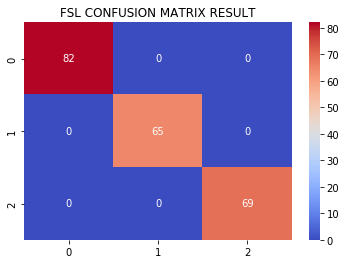

In [340]:
sns.heatmap(fsl_matrix, annot=True, cmap='coolwarm')
plt.figure(figsize=(25, 6))
plt.title('FSL CONFUSION MATRIX RESULT', )
plt.show()

In [298]:
accuracy_score(ytrue, yhat)

1.0

In [347]:
fsl_report = classification_report(ytrue, yhat, target_names=action_labels,output_dict=True)

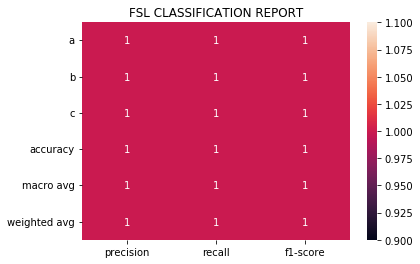

In [352]:
sns.heatmap(pd.DataFrame(fsl_report).iloc[:-1, :].T, annot=True)
plt.title('FSL CLASSIFICATION REPORT', )
plt.show()

### Save Model

In [300]:
# serialize model to JSON
model_json = model.to_json()
with open("FSL_MODEL.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("FSL_MODEL.h5")
print("Saved model to disk")

Saved model to disk


In [301]:
weights_list = model.get_weights()
# weights_list

In [302]:
len(weights_list)

6

### Real-time Prediction Testing

In [4]:
threshold = 0.999
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():


        ret, frame = cap.read()
        image, results = detect_mpKeypoints(frame, holistic)
       
        custom_keypoints(image, results)         
        keypoints = get_keypoints(results)

        if np.argmax(keypoints) == 0:
            pass
        else:
            res = model.predict(np.expand_dims(keypoints, axis=0))
            if np.amax(res) > threshold:
                print('PREDICTIONS: ',np.amax(res), "  |  ALL: ",res)
                print("SIGN: ", action_labels[np.argmax(res)])
            else:
                print('PLEASE TRY AGAIN')
                print('PREDICTIONS: ',res)

        cv2.imshow('FSL RECOGNITION', image)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()

NameError: name 'mp_holistic' is not defined